In [54]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [55]:
dataset_path = './datasets'

DEVICE = torch.device( "cpu")
batch_size = 100

x_dim = 784
hidden_dim = 400
latent_dim = 20

lr = 1e-3
num_epochs = 100

In [56]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor(), # [0, 255] -> [0, 1]
])

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_dataset = MNIST(dataset_path, train=True, transform=mnist_transform, download=True)
test_dataset = MNIST(dataset_path, train=False, transform=mnist_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [57]:
'''
implementation of Gaussian MLP 
'''

class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, hidden_dim) #ax + b
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc3_logvar = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # ela evita o problema de gradiente nulo, mesmo quando a entrada é negativa, o que pode ocorrer durante o treinamento.


        self.training = True
    
    def forward(self, x):
        h_ = self.LeakyReLU(self.fc1(x))
        h_ = self.LeakyReLU(self.fc2(h_))
        mean = self.fc3_mean(h_)
        logvar = self.fc3_logvar(h_)
        return mean, logvar

In [58]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, y_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, y_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        h = self.LeakyReLU(self.fc1(z))
        h = self.LeakyReLU(self.fc2(h))
        y_hat = torch.sigmoid(self.fc3(h))
        return y_hat

In [59]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterize(self, mean, logvar):
        dp = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(dp).to(DEVICE)
        z = mean + dp * epsilon
        return z
    
    def forward(self, x):
        mean, logvar = self.Encoder(x)
        z = self.reparameterize(mean, logvar)
        y_hat = self.Decoder(z)
        return y_hat, mean, logvar
    

In [60]:
encoder = Encoder(x_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, x_dim)

model = Model(encoder, decoder).to(DEVICE)
print("model(celula 16): ", model)

model(celula 16):  Model(
  (Encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=400, bias=True)
    (fc3_mean): Linear(in_features=400, out_features=20, bias=True)
    (fc3_logvar): Linear(in_features=400, out_features=20, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=400, bias=True)
    (fc3): Linear(in_features=400, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)


In [61]:
from torch.optim import Adam

# BCE_loss = nn.BCELoss()
# nn.functional.binary_cross_entropy(y_hat, x, reduction='sum')

def loss_(x, y_hat, mean, logvar):
    reproduction_loss = -torch.sum(x * torch.log(y_hat + 1e-10) + (1 - x) * torch.log(1 - y_hat + 1e-10))
    DKL = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + DKL

optimizer = Adam(model.parameters(), lr=lr)

In [62]:
print("Starting training VAE...")
model.train()

for epoch in range(num_epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(-1, x_dim)

        optimizer.zero_grad()

        y_hat, mean, logvar = model(x)

        # Printando a média e o logvar do primeiro item do batch
        if batch_idx == 0: # Printa apenas no primeiro batch para não inundar a tela
            print(f"Média (primeiros 5 valores do vetor): {mean[0][:5].detach().cpu().numpy()}")
            print(f"LogVar (primeiros 5 valores do vetor): {logvar[0][:5].detach().cpu().numpy()}")

        loss = loss_(x, y_hat, mean, logvar)

        overall_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("\tEpoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
        #     epoch, batch_idx * len(x), len(train_loader.dataset),
        #     100. * batch_idx / len(train_loader), overall_loss / len(train_loader.dataset)))
        # print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))
print("Finish!!")

Starting training VAE...


  0%|          | 2/600 [00:00<00:40, 14.83it/s]

Média (primeiros 5 valores do vetor): [ 0.0216416   0.04797938  0.05958467 -0.00169956 -0.04684561]
LogVar (primeiros 5 valores do vetor): [-0.01543004  0.02166916 -0.03050371 -0.04499912  0.05360552]


100%|██████████| 600/600 [00:19<00:00, 30.31it/s]


	Epoch 1 complete! 	Average Loss:  158.51417467447916


  0%|          | 3/600 [00:00<00:24, 23.96it/s]

Média (primeiros 5 valores do vetor): [0.16193816 0.16418192 0.11190553 1.2147708  0.96922237]
LogVar (primeiros 5 valores do vetor): [-0.15189481 -2.7916281  -0.10458405 -3.480679   -3.4356086 ]


100%|██████████| 600/600 [00:18<00:00, 33.10it/s]


	Epoch 2 complete! 	Average Loss:  118.97557986653646


  0%|          | 1/600 [00:00<01:41,  5.89it/s]

Média (primeiros 5 valores do vetor): [-0.28850567  1.1737726  -0.0822206  -0.048014   -0.33547276]
LogVar (primeiros 5 valores do vetor): [-0.3576072  -4.072607   -0.28086564 -4.184621   -4.1823177 ]


100%|██████████| 600/600 [00:18<00:00, 32.84it/s]


	Epoch 3 complete! 	Average Loss:  112.59937993164063


  0%|          | 3/600 [00:00<00:25, 23.35it/s]

Média (primeiros 5 valores do vetor): [ 0.7554536   0.34145385  0.01158047  2.2300992  -0.96855927]
LogVar (primeiros 5 valores do vetor): [ 0.01548687 -2.593751   -0.07370123 -2.8202286  -4.0534782 ]


100%|██████████| 600/600 [00:17<00:00, 33.68it/s]


	Epoch 4 complete! 	Average Loss:  109.27909182942709


  0%|          | 3/600 [00:00<00:21, 27.31it/s]

Média (primeiros 5 valores do vetor): [ 0.31089798  0.7194837   0.0354821  -0.59757304  0.9920631 ]
LogVar (primeiros 5 valores do vetor): [-0.24263522 -3.1447604  -0.01387415 -3.6889195  -3.1899467 ]


100%|██████████| 600/600 [00:17<00:00, 34.97it/s]


	Epoch 5 complete! 	Average Loss:  107.15916573893229


  0%|          | 3/600 [00:00<00:20, 28.63it/s]

Média (primeiros 5 valores do vetor): [-0.4044654  -0.7723881  -0.1149963   1.5863348   0.04101991]
LogVar (primeiros 5 valores do vetor): [-2.5684467e-01 -3.2579570e+00  1.2241974e-03 -3.0584397e+00
 -4.4508300e+00]


100%|██████████| 600/600 [00:17<00:00, 35.24it/s]


	Epoch 6 complete! 	Average Loss:  105.85645499674479


  0%|          | 3/600 [00:00<00:21, 27.19it/s]

Média (primeiros 5 valores do vetor): [ 0.4707759  -0.68744904  0.0031253   0.68916523  1.2923841 ]
LogVar (primeiros 5 valores do vetor): [-0.44160938 -3.551742   -0.05673664 -3.6209888  -3.750178  ]


100%|██████████| 600/600 [00:16<00:00, 35.61it/s]


	Epoch 7 complete! 	Average Loss:  104.79008159179688


  0%|          | 1/600 [00:00<01:38,  6.06it/s]

Média (primeiros 5 valores do vetor): [ 1.775553    1.3854542  -0.01206641  1.5543506  -0.8493623 ]
LogVar (primeiros 5 valores do vetor): [-1.2798373 -4.5450287 -0.045731  -4.6626253 -4.9120607]


100%|██████████| 600/600 [00:17<00:00, 35.19it/s]


	Epoch 8 complete! 	Average Loss:  103.99068515625


  0%|          | 3/600 [00:00<00:20, 28.96it/s]

Média (primeiros 5 valores do vetor): [ 0.9868202   0.13337323 -0.04242505 -0.6961976  -0.22028229]
LogVar (primeiros 5 valores do vetor): [-0.64279044 -3.24195    -0.02103349 -3.763519   -4.1697345 ]


100%|██████████| 600/600 [00:16<00:00, 35.71it/s]


	Epoch 9 complete! 	Average Loss:  103.37434558919271


  0%|          | 3/600 [00:00<00:20, 29.63it/s]

Média (primeiros 5 valores do vetor): [ 0.41677108 -0.5640446  -0.00456136  0.4406128   0.08342013]
LogVar (primeiros 5 valores do vetor): [-0.7624732  -3.6692886   0.00830498 -3.660863   -4.3477826 ]


100%|██████████| 600/600 [00:17<00:00, 35.25it/s]


	Epoch 10 complete! 	Average Loss:  102.83202443033854


  0%|          | 3/600 [00:00<00:22, 26.80it/s]

Média (primeiros 5 valores do vetor): [-0.32734406 -0.7200104   0.08168075  0.20565605 -0.32396436]
LogVar (primeiros 5 valores do vetor): [-0.6794634  -3.6419744  -0.04183367 -3.9314744  -3.4993358 ]


100%|██████████| 600/600 [00:16<00:00, 35.39it/s]


	Epoch 11 complete! 	Average Loss:  102.40726373697916


  0%|          | 3/600 [00:00<00:21, 28.33it/s]

Média (primeiros 5 valores do vetor): [ 0.422504    0.5873612  -0.01421201 -1.1548111   1.2299511 ]
LogVar (primeiros 5 valores do vetor): [-1.3261751 -4.0922527  0.0319996 -4.1312923 -3.9325967]


100%|██████████| 600/600 [00:16<00:00, 35.63it/s]


	Epoch 12 complete! 	Average Loss:  101.99319444986979


  0%|          | 3/600 [00:00<00:21, 28.22it/s]

Média (primeiros 5 valores do vetor): [ 0.55902666 -1.3392717  -0.07043902  0.2558082   1.0001764 ]
LogVar (primeiros 5 valores do vetor): [-5.8171678e-01 -3.0945721e+00  3.4998730e-04 -3.8354063e+00
 -3.7498517e+00]


100%|██████████| 600/600 [00:16<00:00, 35.59it/s]


	Epoch 13 complete! 	Average Loss:  101.62010997721354


  1%|          | 7/600 [00:00<00:17, 34.72it/s]

Média (primeiros 5 valores do vetor): [-1.6254654   0.69114685 -0.01627965  0.06179573  0.12416194]
LogVar (primeiros 5 valores do vetor): [-1.3225528  -4.603843   -0.04303593 -4.367771   -4.5175686 ]


100%|██████████| 600/600 [00:17<00:00, 35.24it/s]


	Epoch 14 complete! 	Average Loss:  101.31405224609375


  0%|          | 1/600 [00:00<01:41,  5.89it/s]

Média (primeiros 5 valores do vetor): [-0.90922356  0.44382727 -0.02115082  1.4404156   0.8943428 ]
LogVar (primeiros 5 valores do vetor): [-1.1056249  -3.916633   -0.01247462 -3.4299097  -3.9851358 ]


100%|██████████| 600/600 [00:16<00:00, 35.36it/s]


	Epoch 15 complete! 	Average Loss:  101.00113504231771


  0%|          | 3/600 [00:00<00:21, 28.14it/s]

Média (primeiros 5 valores do vetor): [-1.3603672  -0.08714971 -0.04020359 -1.878797   -0.6409856 ]
LogVar (primeiros 5 valores do vetor): [-0.995065   -3.7944703  -0.01375908 -3.8298805  -4.492196  ]


100%|██████████| 600/600 [00:16<00:00, 35.59it/s]


	Epoch 16 complete! 	Average Loss:  100.80670441080728


  0%|          | 3/600 [00:00<00:20, 28.67it/s]

Média (primeiros 5 valores do vetor): [ 0.52422464 -0.5134601   0.01881721 -0.77615714  0.8780912 ]
LogVar (primeiros 5 valores do vetor): [-0.9258615  -3.88066    -0.05351807 -3.6767807  -3.684917  ]


100%|██████████| 600/600 [00:16<00:00, 35.81it/s]


	Epoch 17 complete! 	Average Loss:  100.60160359700521


  0%|          | 3/600 [00:00<00:20, 29.75it/s]

Média (primeiros 5 valores do vetor): [-1.3570498   0.3148445  -0.05643406  0.56508946  2.1868858 ]
LogVar (primeiros 5 valores do vetor): [-0.7792495  -3.7730005   0.03888175 -3.9051933  -2.8581686 ]


100%|██████████| 600/600 [00:17<00:00, 33.48it/s]


	Epoch 18 complete! 	Average Loss:  100.37790825195313


  0%|          | 2/600 [00:00<00:33, 17.75it/s]

Média (primeiros 5 valores do vetor): [ 0.02257684 -0.27039832  0.01764123  1.4662627  -0.5847111 ]
LogVar (primeiros 5 valores do vetor): [-1.2325509  -4.383661   -0.03612863 -3.5784895  -4.680271  ]


100%|██████████| 600/600 [00:17<00:00, 34.64it/s]


	Epoch 19 complete! 	Average Loss:  100.18416917317708


  0%|          | 3/600 [00:00<00:21, 27.78it/s]

Média (primeiros 5 valores do vetor): [-0.7817735   0.7410358   0.14947918 -0.49819148 -0.5110494 ]
LogVar (primeiros 5 valores do vetor): [-0.73259866 -4.0394983  -0.05823966 -4.187649   -4.2306986 ]


100%|██████████| 600/600 [00:16<00:00, 35.72it/s]


	Epoch 20 complete! 	Average Loss:  100.00970712890626


  0%|          | 3/600 [00:00<00:21, 27.73it/s]

Média (primeiros 5 valores do vetor): [ 1.1931257  -1.440882    0.13139886  0.17847851 -0.8983688 ]
LogVar (primeiros 5 valores do vetor): [-6.1112946e-01 -3.6182699e+00  2.7891630e-03 -4.1376419e+00
 -4.7225366e+00]


100%|██████████| 600/600 [00:16<00:00, 35.82it/s]


	Epoch 21 complete! 	Average Loss:  99.82570229492187


  0%|          | 1/600 [00:00<01:32,  6.49it/s]

Média (primeiros 5 valores do vetor): [ 3.0273404  -0.9167483   0.0292902   0.51020783 -1.6590106 ]
LogVar (primeiros 5 valores do vetor): [-1.4859467 -3.7620687 -0.0179979 -4.480236  -5.067229 ]


100%|██████████| 600/600 [00:16<00:00, 35.64it/s]


	Epoch 22 complete! 	Average Loss:  99.6814671061198


  0%|          | 3/600 [00:00<00:20, 28.45it/s]

Média (primeiros 5 valores do vetor): [ 0.3629483  -0.5548738  -0.1970063  -0.42634445 -1.6564924 ]
LogVar (primeiros 5 valores do vetor): [-9.5063078e-01 -2.7982814e+00  1.7717853e-03 -3.3966298e+00
 -3.6577969e+00]


100%|██████████| 600/600 [00:16<00:00, 35.89it/s]


	Epoch 23 complete! 	Average Loss:  99.55703655598958


  0%|          | 3/600 [00:00<00:21, 28.27it/s]

Média (primeiros 5 valores do vetor): [ 0.0996277  -1.5995827   0.07215456  0.7737864   0.4290855 ]
LogVar (primeiros 5 valores do vetor): [-0.5814731  -3.201885    0.03695542 -3.334904   -4.685007  ]


100%|██████████| 600/600 [00:17<00:00, 35.18it/s]


	Epoch 24 complete! 	Average Loss:  99.42823413085938


  0%|          | 3/600 [00:00<00:20, 29.36it/s]

Média (primeiros 5 valores do vetor): [ 0.96439075  0.2807459  -0.00661406 -0.5057844  -0.02330516]
LogVar (primeiros 5 valores do vetor): [-0.3574055  -3.7997522   0.06259698 -3.6094785  -4.215868  ]


100%|██████████| 600/600 [00:16<00:00, 35.44it/s]


	Epoch 25 complete! 	Average Loss:  99.3378861328125


  0%|          | 3/600 [00:00<00:21, 28.39it/s]

Média (primeiros 5 valores do vetor): [ 0.38592035 -0.34006906  0.0228306  -0.7871949   0.88673866]
LogVar (primeiros 5 valores do vetor): [-0.46116    -3.7098875  -0.02809162 -3.8291876  -4.0434136 ]


100%|██████████| 600/600 [00:16<00:00, 35.69it/s]


	Epoch 26 complete! 	Average Loss:  99.17502928059896


  0%|          | 3/600 [00:00<00:21, 28.22it/s]

Média (primeiros 5 valores do vetor): [-0.42521045  0.5417359  -0.10317167  0.33623305 -0.5814611 ]
LogVar (primeiros 5 valores do vetor): [-0.9857311  -3.7642663  -0.03903076 -3.3660846  -4.246769  ]


100%|██████████| 600/600 [00:16<00:00, 35.68it/s]


	Epoch 27 complete! 	Average Loss:  99.03233844401042


  0%|          | 3/600 [00:00<00:22, 27.13it/s]

Média (primeiros 5 valores do vetor): [ 0.16650084  0.22451642 -0.01427958  1.0953556  -1.2948525 ]
LogVar (primeiros 5 valores do vetor): [ 0.15019317 -2.3065739   0.03054965 -2.6899314  -4.8840513 ]


100%|██████████| 600/600 [00:16<00:00, 35.54it/s]


	Epoch 28 complete! 	Average Loss:  98.92021653645833


  0%|          | 1/600 [00:00<01:38,  6.06it/s]

Média (primeiros 5 valores do vetor): [-1.7473189   1.3189394   0.00467921  0.14483286 -0.25357604]
LogVar (primeiros 5 valores do vetor): [-1.2409626  -4.119447    0.00797504 -3.613682   -4.0946712 ]


100%|██████████| 600/600 [00:16<00:00, 35.57it/s]


	Epoch 29 complete! 	Average Loss:  98.88539786783853


  0%|          | 3/600 [00:00<00:20, 29.65it/s]

Média (primeiros 5 valores do vetor): [-0.8669233   1.8614552   0.01241686  1.0760038   1.4188102 ]
LogVar (primeiros 5 valores do vetor): [-1.2261214  -4.132166    0.03281176 -4.5854073  -3.946284  ]


100%|██████████| 600/600 [00:16<00:00, 35.85it/s]


	Epoch 30 complete! 	Average Loss:  98.74159969075521


  0%|          | 3/600 [00:00<00:20, 29.25it/s]

Média (primeiros 5 valores do vetor): [-0.32145035  1.0770636   0.01495828  2.0301619   0.3902325 ]
LogVar (primeiros 5 valores do vetor): [-1.1976409  -3.6109042   0.01622504 -3.1856756  -3.7223496 ]


100%|██████████| 600/600 [00:16<00:00, 35.76it/s]


	Epoch 31 complete! 	Average Loss:  98.62113505859375


  0%|          | 3/600 [00:00<00:23, 25.53it/s]

Média (primeiros 5 valores do vetor): [-0.810269   -0.20489113 -0.03317769  1.5252069   0.16257612]
LogVar (primeiros 5 valores do vetor): [-1.1293983  -3.4283886   0.01827667 -3.2304592  -4.4929395 ]


100%|██████████| 600/600 [00:16<00:00, 35.37it/s]


	Epoch 32 complete! 	Average Loss:  98.61101284179688


  0%|          | 3/600 [00:00<00:21, 27.96it/s]

Média (primeiros 5 valores do vetor): [-0.35427073  0.8826424  -0.05337049 -1.6475399  -0.16881165]
LogVar (primeiros 5 valores do vetor): [-0.74814695 -3.429602   -0.05082556 -3.263245   -4.2256446 ]


100%|██████████| 600/600 [00:16<00:00, 35.52it/s]


	Epoch 33 complete! 	Average Loss:  98.51901243489583


  0%|          | 3/600 [00:00<00:22, 26.31it/s]

Média (primeiros 5 valores do vetor): [ 0.5114981   1.2744937   0.05840681 -1.7652426  -0.7122509 ]
LogVar (primeiros 5 valores do vetor): [-1.2428149  -3.604897   -0.03425541 -3.534162   -4.712085  ]


100%|██████████| 600/600 [00:16<00:00, 35.49it/s]


	Epoch 34 complete! 	Average Loss:  98.44540211588541


  1%|          | 4/600 [00:00<00:18, 31.65it/s]

Média (primeiros 5 valores do vetor): [ 1.0426753   0.2780326   0.05182182  0.67711747 -1.903975  ]
LogVar (primeiros 5 valores do vetor): [-1.0461783  -3.3395486   0.03108469 -3.140068   -4.1012    ]


100%|██████████| 600/600 [00:16<00:00, 35.65it/s]


	Epoch 35 complete! 	Average Loss:  98.39593888346354


  0%|          | 2/600 [00:00<00:30, 19.52it/s]

Média (primeiros 5 valores do vetor): [ 0.89570266 -0.05635996  0.09681655 -1.2399589   1.226224  ]
LogVar (primeiros 5 valores do vetor): [-0.31963968 -3.289257   -0.06038099 -3.424202   -3.6411695 ]


100%|██████████| 600/600 [00:16<00:00, 35.36it/s]


	Epoch 36 complete! 	Average Loss:  98.26126189778645


  0%|          | 3/600 [00:00<00:21, 28.11it/s]

Média (primeiros 5 valores do vetor): [-0.28620028 -0.5415307   0.03830578  0.747928    2.0504503 ]
LogVar (primeiros 5 valores do vetor): [-0.3177944  -3.472935    0.07754546 -3.4340312  -3.4121604 ]


100%|██████████| 600/600 [00:16<00:00, 35.48it/s]


	Epoch 37 complete! 	Average Loss:  98.20043181966146


  0%|          | 1/600 [00:00<01:36,  6.19it/s]

Média (primeiros 5 valores do vetor): [-0.25882423  1.4198124   0.16586807 -0.99150646 -0.44212574]
LogVar (primeiros 5 valores do vetor): [-1.7061751 -4.328951  -0.0731447 -3.9306703 -4.842703 ]


100%|██████████| 600/600 [00:17<00:00, 35.00it/s]


	Epoch 38 complete! 	Average Loss:  98.15352093098959


  0%|          | 3/600 [00:00<00:21, 27.27it/s]

Média (primeiros 5 valores do vetor): [ 0.9545672   0.33569846  0.00132344  0.85678905 -0.5600041 ]
LogVar (primeiros 5 valores do vetor): [-9.1865474e-01 -3.2073574e+00  2.7707294e-03 -3.4781287e+00
 -4.2449660e+00]


100%|██████████| 600/600 [00:17<00:00, 35.13it/s]


	Epoch 39 complete! 	Average Loss:  98.07725102539062


  0%|          | 3/600 [00:00<00:23, 25.02it/s]

Média (primeiros 5 valores do vetor): [-1.0584313   0.41918176  0.05139546  2.6160903   0.20705178]
LogVar (primeiros 5 valores do vetor): [-1.5239118  -3.8429704  -0.01693933 -3.271089   -4.5454884 ]


100%|██████████| 600/600 [00:16<00:00, 35.30it/s]


	Epoch 40 complete! 	Average Loss:  98.019241796875


  0%|          | 3/600 [00:00<00:21, 27.57it/s]

Média (primeiros 5 valores do vetor): [ 0.19038934 -0.71575904  0.07237934 -0.82450414 -1.1734617 ]
LogVar (primeiros 5 valores do vetor): [-6.4243309e-02 -1.9523927e+00 -2.5371369e-04 -2.8846920e+00
 -4.4585600e+00]


100%|██████████| 600/600 [00:17<00:00, 35.02it/s]


	Epoch 41 complete! 	Average Loss:  98.0020524576823


  0%|          | 3/600 [00:00<00:21, 28.27it/s]

Média (primeiros 5 valores do vetor): [ 0.69530696 -0.43928197  0.03923285  0.76790833  0.70830494]
LogVar (primeiros 5 valores do vetor): [-1.3673677  -3.843345   -0.10065337 -4.129118   -4.272153  ]


100%|██████████| 600/600 [00:16<00:00, 35.54it/s]


	Epoch 42 complete! 	Average Loss:  97.93966588541667


  0%|          | 3/600 [00:00<00:22, 26.84it/s]

Média (primeiros 5 valores do vetor): [-0.18893899  0.421759   -0.06884447  0.06219426  0.11405056]
LogVar (primeiros 5 valores do vetor): [-1.0522919  -3.6578412  -0.12554467 -3.6061697  -4.0298643 ]


100%|██████████| 600/600 [00:16<00:00, 35.76it/s]


	Epoch 43 complete! 	Average Loss:  97.84790249023438


  0%|          | 3/600 [00:00<00:20, 29.01it/s]

Média (primeiros 5 valores do vetor): [ 0.56678754 -0.13487177 -0.08163969  0.47203213 -1.5879405 ]
LogVar (primeiros 5 valores do vetor): [-1.7923319  -3.9465725   0.03329862 -3.3265145  -4.5001955 ]


100%|██████████| 600/600 [00:16<00:00, 35.37it/s]


	Epoch 44 complete! 	Average Loss:  97.73333227539062


  0%|          | 3/600 [00:00<00:20, 29.18it/s]

Média (primeiros 5 valores do vetor): [ 1.1086173  -0.31997624 -0.00609365  0.9996993  -1.0616121 ]
LogVar (primeiros 5 valores do vetor): [-1.8302656  -3.6383815   0.02306575 -3.236887   -4.521553  ]


100%|██████████| 600/600 [00:17<00:00, 34.82it/s]


	Epoch 45 complete! 	Average Loss:  97.74412547200521


  0%|          | 1/600 [00:00<01:40,  5.95it/s]

Média (primeiros 5 valores do vetor): [-0.22475958  0.4329208   0.02566646 -1.2557001   0.09167482]
LogVar (primeiros 5 valores do vetor): [-0.31488326 -3.2411885  -0.03612293 -3.2906854  -3.933901  ]


100%|██████████| 600/600 [00:17<00:00, 34.00it/s]


	Epoch 46 complete! 	Average Loss:  97.72701896158854


  0%|          | 3/600 [00:00<00:22, 26.63it/s]

Média (primeiros 5 valores do vetor): [-4.6812475e-02 -1.6169422e+00  1.6948297e-03  6.0631341e-01
 -1.7843075e+00]
LogVar (primeiros 5 valores do vetor): [-0.632948   -3.2078397  -0.06808079 -3.3518329  -4.44483   ]


100%|██████████| 600/600 [00:16<00:00, 35.31it/s]


	Epoch 47 complete! 	Average Loss:  97.64185680338542


  0%|          | 3/600 [00:00<00:22, 26.80it/s]

Média (primeiros 5 valores do vetor): [ 0.6480012   1.9253764   0.04386195  0.4714141  -1.4735181 ]
LogVar (primeiros 5 valores do vetor): [-1.6409539  -3.888031   -0.13069153 -3.538961   -4.739877  ]


100%|██████████| 600/600 [00:19<00:00, 31.49it/s]


	Epoch 48 complete! 	Average Loss:  97.61631474609375


  0%|          | 2/600 [00:00<00:31, 18.98it/s]

Média (primeiros 5 valores do vetor): [ 0.01126394  0.5625595  -0.00690652  0.61250174  0.78089654]
LogVar (primeiros 5 valores do vetor): [-0.66206    -3.604952    0.04112197 -3.5177722  -4.047232  ]


100%|██████████| 600/600 [00:17<00:00, 34.43it/s]


	Epoch 49 complete! 	Average Loss:  97.529584375


  0%|          | 3/600 [00:00<00:21, 27.41it/s]

Média (primeiros 5 valores do vetor): [ 0.9753644  -0.82902384  0.01750979  0.22238943 -1.1920879 ]
LogVar (primeiros 5 valores do vetor): [-0.7374066  -3.490048   -0.02906319 -3.5042868  -4.846492  ]


100%|██████████| 600/600 [00:17<00:00, 34.78it/s]


	Epoch 50 complete! 	Average Loss:  97.48433675130208


  0%|          | 3/600 [00:00<00:22, 27.07it/s]

Média (primeiros 5 valores do vetor): [ 0.59617865 -0.5326917  -0.07663768 -0.7260353  -0.07125944]
LogVar (primeiros 5 valores do vetor): [-0.9129578  -3.2902799  -0.04308177 -3.6549954  -4.40228   ]


100%|██████████| 600/600 [00:16<00:00, 35.45it/s]


	Epoch 51 complete! 	Average Loss:  97.4652997233073


  0%|          | 3/600 [00:00<00:25, 23.15it/s]

Média (primeiros 5 valores do vetor): [ 0.6126943   0.16929415  0.02148257 -1.0016849  -0.04993147]
LogVar (primeiros 5 valores do vetor): [-0.39597166 -3.9161787  -0.01527454 -3.9404473  -4.9527683 ]


100%|██████████| 600/600 [00:17<00:00, 34.93it/s]


	Epoch 52 complete! 	Average Loss:  97.44495750325521


  0%|          | 1/600 [00:00<01:51,  5.38it/s]

Média (primeiros 5 valores do vetor): [-1.6104245   2.0010061   0.00317737  1.6518652   0.16555966]
LogVar (primeiros 5 valores do vetor): [-1.8740017 -4.1079173 -0.0298096 -4.4236784 -4.5041738]


100%|██████████| 600/600 [00:17<00:00, 34.72it/s]


	Epoch 53 complete! 	Average Loss:  97.35737306315104


  0%|          | 3/600 [00:00<00:22, 26.76it/s]

Média (primeiros 5 valores do vetor): [ 0.24939245 -0.14214183 -0.00416766  0.76266897 -1.9753431 ]
LogVar (primeiros 5 valores do vetor): [-0.15750656 -2.2145524  -0.02001726 -2.484228   -4.2969146 ]


100%|██████████| 600/600 [00:17<00:00, 35.21it/s]


	Epoch 54 complete! 	Average Loss:  97.35282859700521


  0%|          | 3/600 [00:00<00:21, 28.20it/s]

Média (primeiros 5 valores do vetor): [ 0.42837894  0.6680687  -0.03855817 -1.821497   -1.0970378 ]
LogVar (primeiros 5 valores do vetor): [-1.2671745  -3.2243743  -0.10861272 -3.419804   -4.5841885 ]


100%|██████████| 600/600 [00:16<00:00, 35.42it/s]


	Epoch 55 complete! 	Average Loss:  97.29584192708333


  0%|          | 3/600 [00:00<00:21, 27.43it/s]

Média (primeiros 5 valores do vetor): [ 0.34176832 -1.142741    0.05524495  0.4293204   0.49334675]
LogVar (primeiros 5 valores do vetor): [-0.79713887 -3.6742282  -0.02011517 -3.7156568  -4.273985  ]


100%|██████████| 600/600 [00:16<00:00, 35.54it/s]


	Epoch 56 complete! 	Average Loss:  97.27266772460938


  0%|          | 3/600 [00:00<00:21, 27.80it/s]

Média (primeiros 5 valores do vetor): [-0.14625117 -0.65442324 -0.02479823  0.6571405  -0.48422027]
LogVar (primeiros 5 valores do vetor): [-1.0230967  -4.0612993  -0.02960637 -3.753892   -4.565634  ]


100%|██████████| 600/600 [00:16<00:00, 35.47it/s]


	Epoch 57 complete! 	Average Loss:  97.20878251953125


  0%|          | 1/600 [00:00<01:53,  5.30it/s]

Média (primeiros 5 valores do vetor): [-0.39773917 -0.85828984 -0.05031579 -1.4425471   1.2886755 ]
LogVar (primeiros 5 valores do vetor): [-0.13539112 -3.019843   -0.03385516 -2.651752   -3.6759207 ]


100%|██████████| 600/600 [00:17<00:00, 35.01it/s]


	Epoch 58 complete! 	Average Loss:  97.24231149088541


  0%|          | 3/600 [00:00<00:21, 27.68it/s]

Média (primeiros 5 valores do vetor): [ 0.12159634  1.105872    0.08107071 -1.6396407  -1.3652222 ]
LogVar (primeiros 5 valores do vetor): [-5.4384971e-01 -3.1706333e+00  3.2887175e-03 -3.4926541e+00
 -4.9190607e+00]


100%|██████████| 600/600 [00:16<00:00, 35.31it/s]


	Epoch 59 complete! 	Average Loss:  97.1643237141927


  0%|          | 3/600 [00:00<00:21, 27.32it/s]

Média (primeiros 5 valores do vetor): [ 0.91492575  1.3811162   0.04565184 -0.68537515 -0.09201102]
LogVar (primeiros 5 valores do vetor): [-0.23153739 -2.836113   -0.00873583 -3.186346   -4.966009  ]


100%|██████████| 600/600 [00:17<00:00, 34.46it/s]


	Epoch 60 complete! 	Average Loss:  97.0785044108073


  0%|          | 3/600 [00:00<00:21, 27.22it/s]

Média (primeiros 5 valores do vetor): [ 1.1382062  -0.01638778 -0.1695635  -0.70155066 -1.7818136 ]
LogVar (primeiros 5 valores do vetor): [-1.1129749  -3.1173363  -0.01403626 -3.446676   -4.8983593 ]


100%|██████████| 600/600 [00:18<00:00, 32.58it/s]


	Epoch 61 complete! 	Average Loss:  97.12030862630208


  0%|          | 3/600 [00:00<00:21, 27.28it/s]

Média (primeiros 5 valores do vetor): [-3.3310404   0.40562144  0.10322094 -1.1360261  -2.1978543 ]
LogVar (primeiros 5 valores do vetor): [-1.5587064 -3.8879128 -0.1038416 -3.8466763 -4.2056813]


100%|██████████| 600/600 [00:17<00:00, 34.75it/s]


	Epoch 62 complete! 	Average Loss:  97.01030582682291


  0%|          | 2/600 [00:00<00:30, 19.64it/s]

Média (primeiros 5 valores do vetor): [ 0.2620843  -2.2469993  -0.00337452  0.8540096   1.8243313 ]
LogVar (primeiros 5 valores do vetor): [-0.761222   -2.8850956  -0.04644632 -3.5875936  -3.5910645 ]


100%|██████████| 600/600 [00:17<00:00, 33.84it/s]


	Epoch 63 complete! 	Average Loss:  97.01408875325521


  0%|          | 3/600 [00:00<00:21, 27.22it/s]

Média (primeiros 5 valores do vetor): [-0.70928586  1.0459853   0.06923398 -0.9094591   2.5675097 ]
LogVar (primeiros 5 valores do vetor): [-0.9462037  -3.9933386  -0.07831121 -4.040291   -3.571462  ]


100%|██████████| 600/600 [00:17<00:00, 34.16it/s]


	Epoch 64 complete! 	Average Loss:  96.99159868164062


  0%|          | 3/600 [00:00<00:21, 28.29it/s]

Média (primeiros 5 valores do vetor): [-0.34734708 -0.06546091  0.08225161  0.9680093  -0.591212  ]
LogVar (primeiros 5 valores do vetor): [-1.533072   -3.5366893  -0.03646832 -3.8085814  -5.3028555 ]


100%|██████████| 600/600 [00:17<00:00, 35.27it/s]


	Epoch 65 complete! 	Average Loss:  96.93920222981771


  0%|          | 3/600 [00:00<00:22, 26.84it/s]

Média (primeiros 5 valores do vetor): [-0.2561006   0.2631585  -0.04820506  0.69363093 -2.39471   ]
LogVar (primeiros 5 valores do vetor): [-3.1841722e-01 -2.3615012e+00 -3.6281198e-03 -2.2416553e+00
 -3.6461887e+00]


100%|██████████| 600/600 [00:17<00:00, 35.21it/s]


	Epoch 66 complete! 	Average Loss:  96.92740104166667


  0%|          | 0/600 [00:00<?, ?it/s]

Média (primeiros 5 valores do vetor): [ 0.25370347  0.2581564   0.1217359  -0.83371896 -0.07402883]
LogVar (primeiros 5 valores do vetor): [-0.9929826  -3.5765884  -0.01232834 -3.5451837  -4.692706  ]


100%|██████████| 600/600 [00:16<00:00, 35.34it/s]


	Epoch 67 complete! 	Average Loss:  96.82896977539062


  0%|          | 3/600 [00:00<00:22, 26.77it/s]

Média (primeiros 5 valores do vetor): [ 0.62238     0.17018738  0.07189482 -0.7592321  -1.2916923 ]
LogVar (primeiros 5 valores do vetor): [-1.1815597  -3.2426598  -0.06646778 -3.5787585  -4.5124283 ]


100%|██████████| 600/600 [00:16<00:00, 35.48it/s]


	Epoch 68 complete! 	Average Loss:  96.88459646809896


  0%|          | 3/600 [00:00<00:21, 27.29it/s]

Média (primeiros 5 valores do vetor): [ 0.6140685  -0.27091318  0.03312686 -0.13975199  0.87760663]
LogVar (primeiros 5 valores do vetor): [-0.6166841  -3.6169195  -0.10671657 -3.340561   -4.5750237 ]


100%|██████████| 600/600 [00:18<00:00, 32.44it/s]


	Epoch 69 complete! 	Average Loss:  96.86119783528646


  0%|          | 3/600 [00:00<00:21, 27.74it/s]

Média (primeiros 5 valores do vetor): [-0.54420435 -0.27159312 -0.00311908  0.2543361   1.6264485 ]
LogVar (primeiros 5 valores do vetor): [-1.4378401  -3.8233151  -0.09378558 -3.9414268  -4.096115  ]


100%|██████████| 600/600 [00:17<00:00, 34.44it/s]


	Epoch 70 complete! 	Average Loss:  96.82870735677083


  0%|          | 3/600 [00:00<00:24, 24.87it/s]

Média (primeiros 5 valores do vetor): [-1.3981295   1.7577056   0.1128764  -1.2797413   0.07275204]
LogVar (primeiros 5 valores do vetor): [-1.6439514  -3.7848873  -0.10669929 -3.6823564  -5.0330806 ]


100%|██████████| 600/600 [00:17<00:00, 33.94it/s]


	Epoch 71 complete! 	Average Loss:  96.7800046875


  0%|          | 0/600 [00:00<?, ?it/s]

Média (primeiros 5 valores do vetor): [ 1.5923303   0.49721837  0.07309572  1.528019   -0.69774485]
LogVar (primeiros 5 valores do vetor): [-1.7212464  -3.567436   -0.11074997 -3.3937907  -4.5659266 ]


100%|██████████| 600/600 [00:17<00:00, 33.44it/s]


	Epoch 72 complete! 	Average Loss:  96.76746207682292


  0%|          | 2/600 [00:00<00:32, 18.54it/s]

Média (primeiros 5 valores do vetor): [ 0.7509484  -0.16148484  0.03780921  0.50559473  0.44717818]
LogVar (primeiros 5 valores do vetor): [-0.7920083  -3.551148   -0.04822625 -3.3372726  -4.6033363 ]


100%|██████████| 600/600 [00:17<00:00, 34.80it/s]


	Epoch 73 complete! 	Average Loss:  96.70521513671875


  0%|          | 3/600 [00:00<00:21, 27.88it/s]

Média (primeiros 5 valores do vetor): [ 0.20013086  0.48585477  0.02210134 -1.0269241  -1.8655301 ]
LogVar (primeiros 5 valores do vetor): [-1.6278296 -3.349926   0.0131043 -3.6622682 -4.700555 ]


100%|██████████| 600/600 [00:17<00:00, 34.30it/s]


	Epoch 74 complete! 	Average Loss:  96.70771056315104


  0%|          | 2/600 [00:00<00:30, 19.65it/s]

Média (primeiros 5 valores do vetor): [ 0.7012017  -0.4982959  -0.04678664 -0.8476136  -1.6562729 ]
LogVar (primeiros 5 valores do vetor): [-1.095315  -3.5507398 -0.0514413 -3.7207267 -4.9992247]


100%|██████████| 600/600 [00:17<00:00, 34.82it/s]


	Epoch 75 complete! 	Average Loss:  96.68057202148438


  0%|          | 3/600 [00:00<00:22, 26.90it/s]

Média (primeiros 5 valores do vetor): [ 0.37867254  0.2649191  -0.0375053  -0.26859158 -2.1990185 ]
LogVar (primeiros 5 valores do vetor): [-0.5651503 -3.3532894 -0.0897059 -3.2866879 -4.0244346]


100%|██████████| 600/600 [00:17<00:00, 34.51it/s]


	Epoch 76 complete! 	Average Loss:  96.64535003255209


  0%|          | 1/600 [00:00<01:38,  6.07it/s]

Média (primeiros 5 valores do vetor): [-0.8427336  -0.7522979   0.11933728 -2.482699   -0.64123917]
LogVar (primeiros 5 valores do vetor): [-1.4423864  -2.9700668  -0.04359928 -3.2704048  -4.3790665 ]


100%|██████████| 600/600 [00:17<00:00, 34.77it/s]


	Epoch 77 complete! 	Average Loss:  96.604241796875


  0%|          | 3/600 [00:00<00:25, 23.59it/s]

Média (primeiros 5 valores do vetor): [-0.54746747 -0.05395308 -0.08906501 -0.91305304 -2.1156235 ]
LogVar (primeiros 5 valores do vetor): [-1.2066877  -3.1656985  -0.10546915 -3.4699168  -4.1600513 ]


100%|██████████| 600/600 [00:17<00:00, 34.95it/s]


	Epoch 78 complete! 	Average Loss:  96.61634010416667


  0%|          | 3/600 [00:00<00:22, 26.93it/s]

Média (primeiros 5 valores do vetor): [ 0.92151487 -0.04045796 -0.08405833  1.2129806  -1.3969978 ]
LogVar (primeiros 5 valores do vetor): [-1.4604394  -3.5079381  -0.03723715 -3.1509109  -4.6045136 ]


100%|██████████| 600/600 [00:16<00:00, 35.57it/s]


	Epoch 79 complete! 	Average Loss:  96.5354231282552


  0%|          | 3/600 [00:00<00:22, 26.07it/s]

Média (primeiros 5 valores do vetor): [ 0.2849137   0.230731    0.04592711 -1.8569705   0.28577965]
LogVar (primeiros 5 valores do vetor): [-1.3256646  -3.3700657  -0.01755371 -3.330443   -3.890235  ]


100%|██████████| 600/600 [00:17<00:00, 35.07it/s]


	Epoch 80 complete! 	Average Loss:  96.5632118001302


  0%|          | 3/600 [00:00<00:23, 25.43it/s]

Média (primeiros 5 valores do vetor): [ 1.2226609  -0.62377965  0.0342613   0.39377964 -0.79076785]
LogVar (primeiros 5 valores do vetor): [-1.3488305 -3.5075998 -0.052389  -3.258857  -5.0978446]


100%|██████████| 600/600 [00:16<00:00, 35.37it/s]


	Epoch 81 complete! 	Average Loss:  96.52173675130209


  0%|          | 3/600 [00:00<00:22, 26.59it/s]

Média (primeiros 5 valores do vetor): [ 0.5925695   1.1317564   0.03737289 -0.3278574   1.0099695 ]
LogVar (primeiros 5 valores do vetor): [-0.6223012  -3.9932725  -0.01407294 -3.740584   -4.0540724 ]


100%|██████████| 600/600 [00:16<00:00, 35.60it/s]


	Epoch 82 complete! 	Average Loss:  96.51257504882813


  0%|          | 3/600 [00:00<00:21, 27.26it/s]

Média (primeiros 5 valores do vetor): [ 1.7523569  -1.0131896   0.02787584  0.4929587   0.2124176 ]
LogVar (primeiros 5 valores do vetor): [-0.6474371  -3.5766435  -0.04858825 -3.5353093  -4.7283564 ]


100%|██████████| 600/600 [00:17<00:00, 35.24it/s]


	Epoch 83 complete! 	Average Loss:  96.49302446289063


  0%|          | 1/600 [00:00<01:54,  5.25it/s]

Média (primeiros 5 valores do vetor): [ 0.5897668 -0.5273475  0.0677118  0.7233288  0.7863312]
LogVar (primeiros 5 valores do vetor): [-0.94625115 -3.5281458   0.0313764  -3.416316   -4.1895223 ]


100%|██████████| 600/600 [00:17<00:00, 34.98it/s]


	Epoch 84 complete! 	Average Loss:  96.48571904296875


  0%|          | 3/600 [00:00<00:22, 26.22it/s]

Média (primeiros 5 valores do vetor): [-0.22277033  1.8727987  -0.01384283 -0.526061   -2.0210319 ]
LogVar (primeiros 5 valores do vetor): [-0.4551347  -2.9781742  -0.04139543 -2.9000025  -4.1560354 ]


100%|██████████| 600/600 [00:17<00:00, 35.19it/s]


	Epoch 85 complete! 	Average Loss:  96.41793966471354


  0%|          | 3/600 [00:00<00:22, 26.84it/s]

Média (primeiros 5 valores do vetor): [ 0.40347067  0.36102614  0.11372508 -0.7600851  -0.34566694]
LogVar (primeiros 5 valores do vetor): [-0.19578117 -3.2091224  -0.031562   -2.8538013  -4.405739  ]


100%|██████████| 600/600 [00:16<00:00, 35.43it/s]


	Epoch 86 complete! 	Average Loss:  96.41302918294271


  0%|          | 3/600 [00:00<00:21, 27.15it/s]

Média (primeiros 5 valores do vetor): [ 0.21309116  0.8872504   0.00306338  0.8441942  -1.5607054 ]
LogVar (primeiros 5 valores do vetor): [-0.89123136 -3.6835117   0.0562284  -3.2657113  -4.683632  ]


100%|██████████| 600/600 [00:16<00:00, 35.46it/s]


	Epoch 87 complete! 	Average Loss:  96.38468103841146


  0%|          | 3/600 [00:00<00:22, 27.00it/s]

Média (primeiros 5 valores do vetor): [-0.17911673  0.5344696  -0.03887396  0.325865   -2.2212458 ]
LogVar (primeiros 5 valores do vetor): [-0.6824093  -3.299645    0.01895892 -3.321558   -3.9886343 ]


100%|██████████| 600/600 [00:17<00:00, 34.91it/s]


	Epoch 88 complete! 	Average Loss:  96.39907900390625


  0%|          | 2/600 [00:00<00:33, 17.85it/s]

Média (primeiros 5 valores do vetor): [ 0.02072078  0.18381965  0.01303032 -0.3006971  -0.19452488]
LogVar (primeiros 5 valores do vetor): [-0.3402156 -3.422414   0.0155086 -3.5043557 -5.117565 ]


100%|██████████| 600/600 [00:17<00:00, 35.29it/s]


	Epoch 89 complete! 	Average Loss:  96.35904612630209


  0%|          | 3/600 [00:00<00:22, 26.10it/s]

Média (primeiros 5 valores do vetor): [-1.323086   -2.226911    0.00370315  0.4288755  -2.036959  ]
LogVar (primeiros 5 valores do vetor): [-1.0675882  -2.8511562  -0.10567725 -2.994241   -4.2604704 ]


100%|██████████| 600/600 [00:17<00:00, 35.25it/s]


	Epoch 90 complete! 	Average Loss:  96.389351953125


  0%|          | 3/600 [00:00<00:22, 26.39it/s]

Média (primeiros 5 valores do vetor): [ 1.9662515  -0.8947566   0.04904205  0.53774786  0.2007002 ]
LogVar (primeiros 5 valores do vetor): [-0.8823519  -3.525398    0.02360355 -3.5408227  -4.667984  ]


100%|██████████| 600/600 [00:17<00:00, 35.13it/s]


	Epoch 91 complete! 	Average Loss:  96.3148768391927


  0%|          | 3/600 [00:00<00:21, 27.33it/s]

Média (primeiros 5 valores do vetor): [-0.16353542  0.9970473  -0.00879126  0.41131526  0.38137972]
LogVar (primeiros 5 valores do vetor): [-0.1475471  -3.2491055   0.01979673 -3.091438   -5.3916526 ]


100%|██████████| 600/600 [00:17<00:00, 34.90it/s]


	Epoch 92 complete! 	Average Loss:  96.31197172851563


  0%|          | 3/600 [00:00<00:24, 24.76it/s]

Média (primeiros 5 valores do vetor): [-0.08459756 -0.05641536  0.01864029 -0.9444072   0.23057976]
LogVar (primeiros 5 valores do vetor): [-0.9435045  -3.5993853   0.02918245 -3.5087917  -4.544056  ]


100%|██████████| 600/600 [00:17<00:00, 35.29it/s]


	Epoch 93 complete! 	Average Loss:  96.25969161783854


  0%|          | 2/600 [00:00<00:58, 10.20it/s]

Média (primeiros 5 valores do vetor): [ 0.666475    1.0626067   0.15745008 -0.63684076 -1.9568248 ]
LogVar (primeiros 5 valores do vetor): [-0.6374769  -3.0446405   0.02636161 -3.3635688  -4.980653  ]


100%|██████████| 600/600 [00:17<00:00, 34.63it/s]


	Epoch 94 complete! 	Average Loss:  96.2692389811198


  0%|          | 3/600 [00:00<00:23, 24.94it/s]

Média (primeiros 5 valores do vetor): [ 0.10495389 -0.65162027  0.03643718  0.7858274  -2.5330226 ]
LogVar (primeiros 5 valores do vetor): [-0.23329058 -2.6033196  -0.01723956 -2.1920452  -3.490099  ]


100%|██████████| 600/600 [00:17<00:00, 34.46it/s]


	Epoch 95 complete! 	Average Loss:  96.26029768880208


  0%|          | 3/600 [00:00<00:22, 26.45it/s]

Média (primeiros 5 valores do vetor): [-0.08160973 -1.5322042   0.01764058 -0.23945796 -0.6111129 ]
LogVar (primeiros 5 valores do vetor): [-0.4649753  -2.9524655  -0.05400851 -2.896834   -4.477618  ]


100%|██████████| 600/600 [00:17<00:00, 34.82it/s]


	Epoch 96 complete! 	Average Loss:  96.26375185546875


  0%|          | 3/600 [00:00<00:23, 25.68it/s]

Média (primeiros 5 valores do vetor): [ 0.4369511   1.5375733  -0.0139447  -1.1307206  -0.28775638]
LogVar (primeiros 5 valores do vetor): [-0.48311317 -2.7725818  -0.03296144 -3.2625074  -4.7954183 ]


100%|██████████| 600/600 [00:17<00:00, 35.02it/s]


	Epoch 97 complete! 	Average Loss:  96.19613784179687


  0%|          | 3/600 [00:00<00:23, 25.26it/s]

Média (primeiros 5 valores do vetor): [ 1.009973   -0.24363323 -0.13352603  0.9313009  -0.65187556]
LogVar (primeiros 5 valores do vetor): [-0.8413757  -3.711604    0.00931841 -3.3390703  -5.0318832 ]


100%|██████████| 600/600 [00:16<00:00, 35.46it/s]


	Epoch 98 complete! 	Average Loss:  96.15816424153645


  0%|          | 3/600 [00:00<00:24, 24.63it/s]

Média (primeiros 5 valores do vetor): [-0.0236955   0.45585874  0.00814383 -0.30959028 -0.0416689 ]
LogVar (primeiros 5 valores do vetor): [-0.48664743 -3.368888   -0.06045645 -3.4285295  -5.1641545 ]


100%|██████████| 600/600 [00:17<00:00, 35.02it/s]


	Epoch 99 complete! 	Average Loss:  96.19201564127604


  0%|          | 3/600 [00:00<00:22, 26.89it/s]

Média (primeiros 5 valores do vetor): [ 0.07374316  0.5183469   0.06278753  0.91310555 -0.15678546]
LogVar (primeiros 5 valores do vetor): [-0.11208039 -2.8319707  -0.03256492 -2.9914272  -5.2224684 ]


100%|██████████| 600/600 [00:16<00:00, 35.30it/s]

	Epoch 100 complete! 	Average Loss:  96.1824388671875
Finish!!


In [63]:

import matplotlib.pyplot as plt

In [64]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim).to(DEVICE)
        y_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [65]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    grid_size = int(np.sqrt(idx))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples

    for i in range(idx):
        if i < len(x):
            axes[i].imshow(x[i], cmap='gray')
            axes[i].axis('off') # Remove os números dos eixos
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

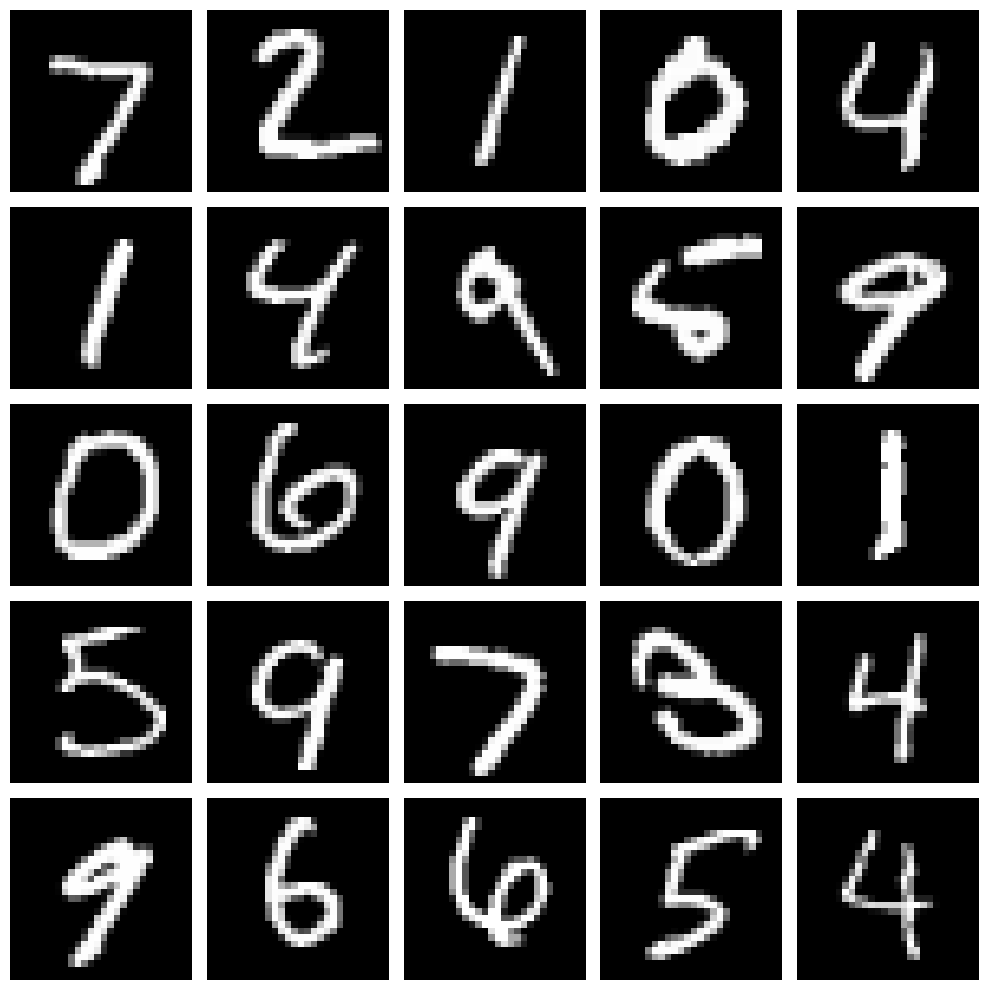

In [66]:
show_image(x, idx=25)

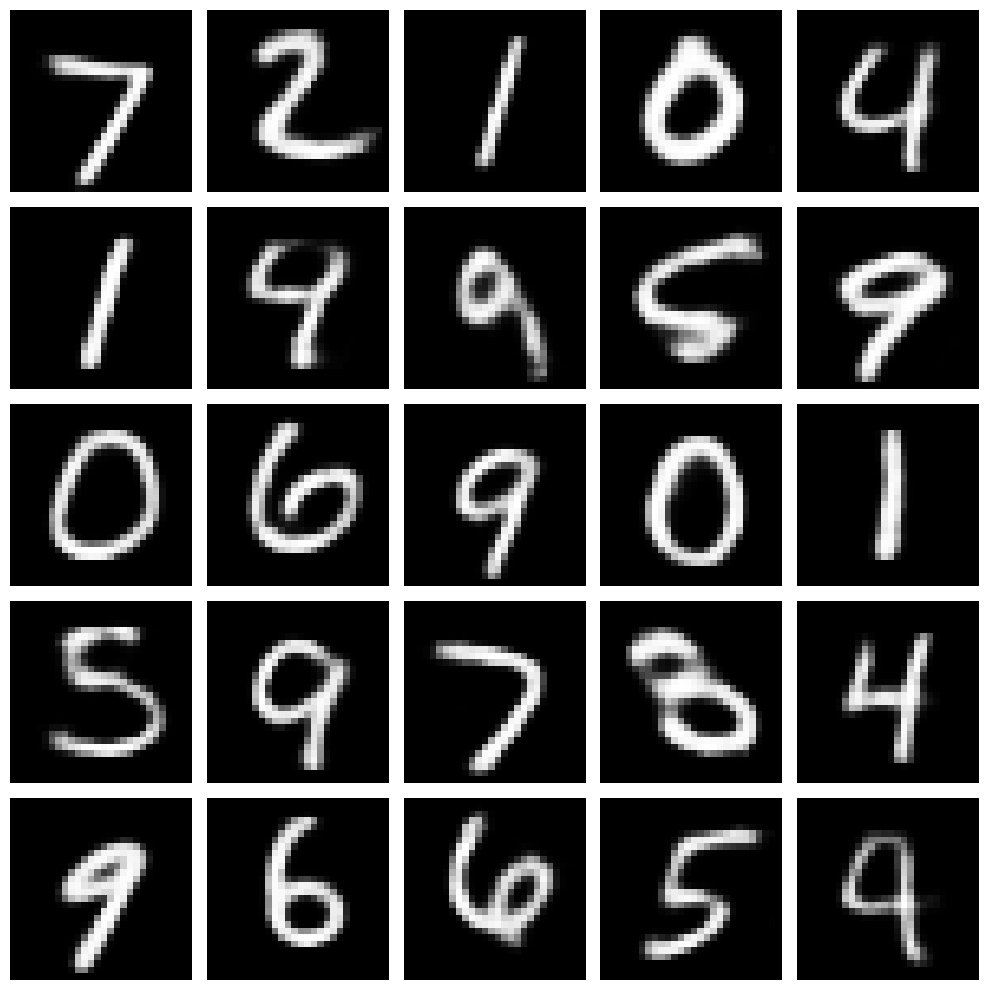

In [67]:
show_image(y_hat, idx=25)

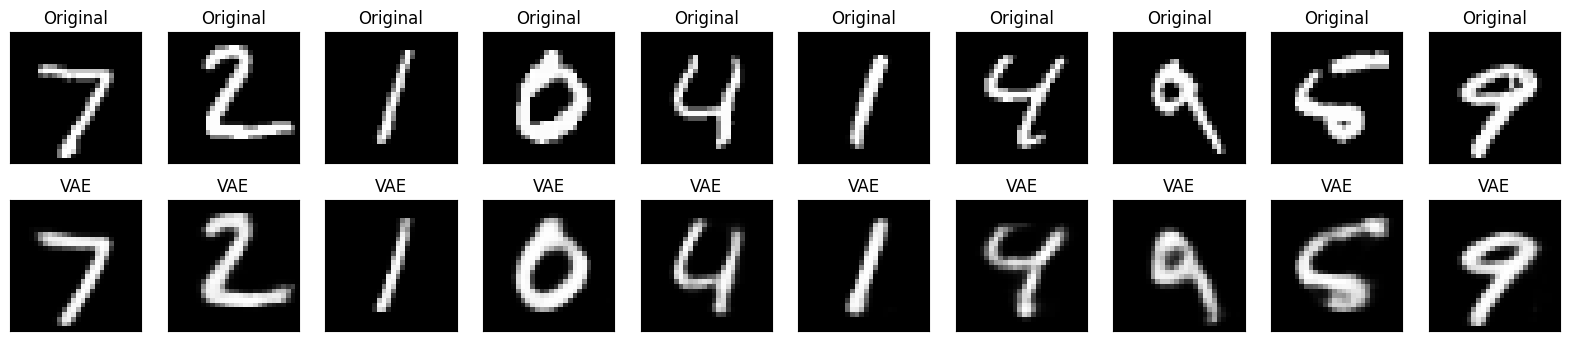

In [68]:
import matplotlib.pyplot as plt
import torch

model.eval() # Coloca o modelo em modo de avaliação
with torch.no_grad():
    # Pega um batch de teste
    for x, _ in test_loader:
        x = x.view(-1, x_dim).to(DEVICE)
        y_hat, _, _ = model(x) # Passa pelo VAE
        break

# Plotando os resultados (Original vs Reconstrução)
n = 10  # número de dígitos a exibir
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagem Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i].cpu().reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagem Reconstruída
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_hat[i].cpu().reshape(28, 28), cmap='gray')
    plt.title("VAE")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()